In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import os
import matplotlib.pyplot as plt
from itertools import combinations
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from pprint import pprint
from pingouin import partial_corr
from statsmodels.tsa.stattools import adfuller, pacf, acf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.iolib import SimpleTable
from statsmodels.stats.stattools import durbin_watson
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.stats.diagnostic import het_breuschpagan, het_goldfeldquandt, het_white, het_arch, acorr_ljungbox
from statistics import *
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA
from scipy.optimize import curve_fit
from scipy.stats.stats import kurtosis, skew
from scipy.stats import boxcox
from IPython.core.display import display
from patsy import dmatrices
from statsmodels.tsa.statespace.sarimax import SARIMAX
from arch import arch_model
from arch.univariate import ARX, ARCH, GARCH
import warnings
from datetime import datetime, timedelta
import seaborn as sns
warnings.filterwarnings('ignore')

plt.rcParams["figure.figsize"] = (15,8)
plt.rcParams["axes.labelsize"] = 20
plt.rcParams['xtick.labelsize'] = 15
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['grid.linewidth'] = .5
plt.rcParams['axes.grid'] = True
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['figure.titlesize'] = 20
plt.rcParams['legend.fontsize'] = 15

factors_dir = os.path.join('data', 'factors')

def read_csv(*args, **kwargs):
    kwargs.setdefault('parse_dates', ['Date'])
    kwargs.setdefault('index_col', 'Date')
    res = pd.read_csv(*args, **kwargs)
    if res.size < 50:
        res = res.resample('1y').last()
    elif res.size < 600:
        res = res.resample('1m').last()
    else:
        res = res.append(res.resample('1m').last())
    return res

def investing_com_convert_csv(path):
    df = pd.read_csv(path, dayfirst=True, parse_dates=['Дата'], thousands='.', decimal=',')
    df.columns = ['Date', 'Close', 'Open', 'Max', 'Min', 'Vol', 'Change']
    df = df.set_index('Date').sort_index()
    return df

In [2]:
# Индекс реального эффективного курса рубля, инвестиции в основной капитал

In [3]:
# Создание series'ов и dataframe'ов
factors_csv = os.listdir(factors_dir)
for csv_file in factors_csv:
    if csv_file.startswith('.') or not csv_file.endswith('.csv'):
        continue
    var_name = os.path.splitext(csv_file)[0].lower()
    df_name = f'{var_name}_df'
    series_name = f'{var_name}_series'
    globals()[df_name] = read_csv(os.path.join(factors_dir, csv_file))
    globals()[series_name] = globals()[df_name].Close.resample('1d').last().dropna()

In [4]:
all_df = pd.DataFrame({
    # Индекс РТС
    'RTSI': rtsi_series,
    # Индекс S&P 500
    'SP500': sp500_series,
    # FTSE - Англия
    'FTSE': ftse_series,
    # DAX - Германия
    'DAX': dax_series,
    # SSE - Китай
    'SSE': sse_series,
    # Нефть Brent
    'Brent': brent_series,
    # USD/RUB
    'USD': usd_series,
    # Темпы роста ВВП РФ
    # 'GDP': gdp_series,
    # Золото
    'Gold': gold_series,
    # Уровень безработицы в РФ
    'Unemployment': unemployment_series,
    # Индекс потребительских цен
    # 'CPI': cpi_series,
    # Индекс потребительских цен погодично
    # 'CPI_year': cpi_year_series,
    # Индекс потребительских цен относительно 2000 года
    # 'CPI2000': cpi2000_series,
    # Индекс потребительских цен относительно 1996 года
    # 'CPI1996': cpi1996_series,
    # Ставки по межбанковским кредитам
    'InterbankRate': interbank_rate_series,
    # Доходность 6 месячных облигаций США
    'USA6mBond': usa_6m_bond_series,
    # Инвестиции в основной капитал
    # 'capital_investment': capital_investment_series,
    # Внешняя торговля РФ
    'international_trade': international_trade_series,
    # Индекс производительности труда
    'labor_performance': labor_performance_series,
    # Индекс промышленного производства
    'industrial_production': industrial_production_series,
    # Ключевая ставка
    'key_rate': key_rate_series,
    # Остатки на корреспондентских счетах
    # 'correspondent_accounts': correspondent_accounts_series,
    # Остатки на корреспондентских счетах (средние скорректированные)
    'correspondent_accounts_mean_scorr': correspondent_accounts_mean_scorr_series,
    # Номинальная зарплата
    # 'nominal_salary': nominal_salary_series,
    # Скорректированная номинальная зарплата
    'nominal_salary_scorr': nominal_salary_scorr_series,
    # ВВП РФ в абсолютном значении
    # 'abs_gdp': abs_gdp_series,
    # Скорректированный ВВП РФ в абсолютном значении
    'abs_gdp_scorr': abs_gdp_scorr_series,
    # Скорректированные инвестиции в основной капитал
    'capital_investment_scorr': capital_investment_series
})

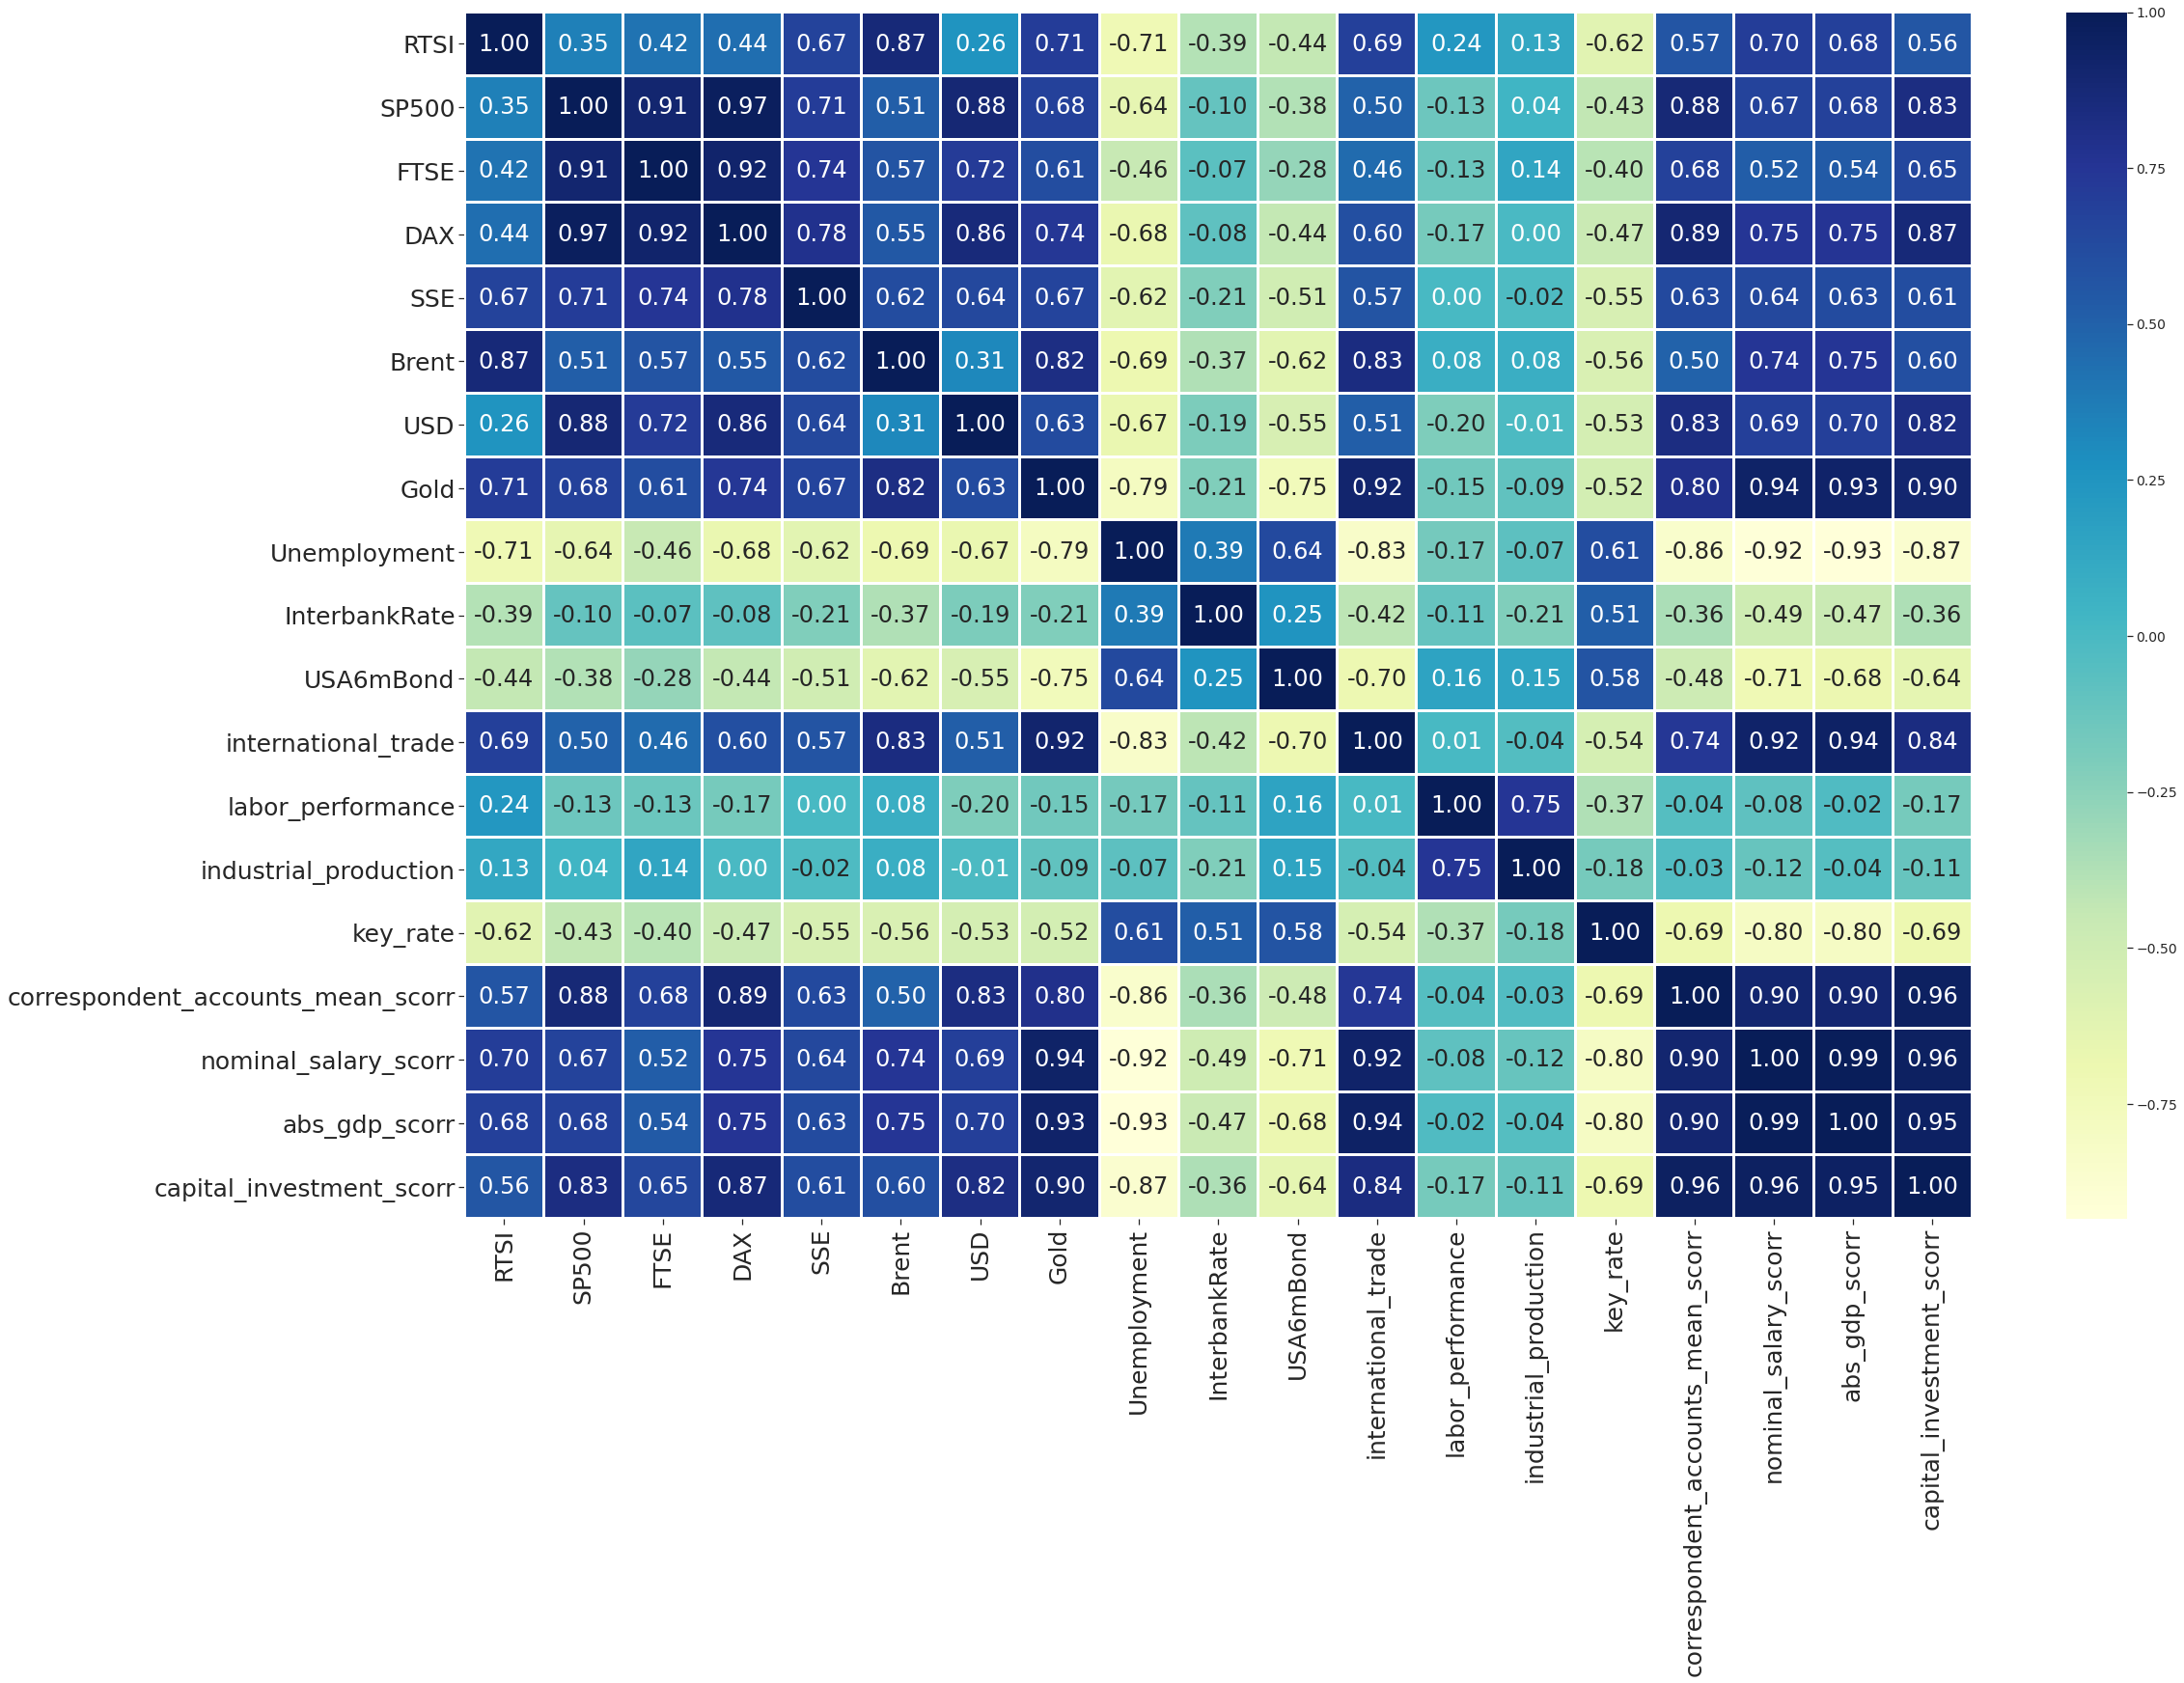

In [5]:
fig, ax = plt.subplots(figsize=(35, 23))
ax.tick_params(labelsize=25)
sns.heatmap(
    all_df.corr(), cmap='YlGnBu', annot=True, linewidths=2, 
    ax=ax, annot_kws={'size': 24},
    fmt='.2f'
);

In [6]:
# Добавить dax_sp500 и sse_sp500

In [7]:
columns = all_df.columns.drop(['RTSI'])

In [8]:
max_mc = []
# for i in range(5, len(columns)+1):
#     print(i)
#     for factors in combinations(columns, i):
#         res = np.linalg.det(all_df[list(factors)].corr())
#         if res >= .1:
#             max_mc.append((res, factors))

In [9]:
test_df = all_df.copy()
test_df['USD2'] = test_df.USD ** 2
test_df['USD3'] = test_df.USD ** 3
test_df['Brent2'] = test_df.Brent ** 2
test_df['Brent3'] = test_df.Brent ** 3
test_df['dax_sp500'] = dax_sp500
test_df['sse_sp500'] = sse_sp500

NameError: name 'dax_sp500' is not defined

In [ ]:
smf.ols(
    'RTSI ~ Brent + InterbankRate + USA6mBond + key_rate + Gold + np.log(USD) + sse_sp500', 
    data=test_df
).fit().summary()

## Метод главных компонент

### Расчет факторных нагрузок

In [ ]:
tmp = all_df[['SP500', 'SSE', 'DAX', 'FTSE']]['1996':'2019'].resample('1y').last()
tmp_centered = [tmp[col]-tmp[col].mean() for col in tmp.columns]
tmp_cov = np.cov(tmp_centered)
_, tmp_eig = np.linalg.eig(tmp_cov)
tmp_v = tmp_eig[:, 0]

In [ ]:
for x, y, name in zip(*tmp_eig[:2], tmp.columns):
    plt.scatter(x, y, s=100);
    plt.text(x+.01, y+.03, name, fontsize=20, color='#55ff')
    
ax = plt.gca()
ax.spines['left'].set_position('zero')
ax.spines['left'].set_linewidth(.5)
ax.spines['bottom'].set_position('zero')
ax.spines['bottom'].set_linewidth(.5)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

### Расчет значений (PC)

In [ ]:
pca = PCA(n_components=2)
xpca_reduced = pca.fit_transform(tmp)
print('Процент объясненной дисперсии', pca.explained_variance_ratio_)

dax_sp500 = pd.Series(xpca_reduced[:, 0], index=tmp.index)
sse_sp500 = pd.Series(xpca_reduced[:, 1], index=tmp.index)